In [195]:
from conllu import parse

In [196]:
import pandas as pd
import numpy as np
import os

In [197]:
p = '../../prompts/rendered/merged_data.parquet'

df = pd.read_parquet(p)

In [198]:
df.drop(["message_text"], axis=1, inplace=True)

In [199]:
# Filter the ones without udpipe_result
df = df[df['udpipe_result'] != ""]

In [200]:
from collections import Counter

In [201]:
class LinguisticComplexityAnalyzer:
    def __init__(self):
        pass

    def count_func(self, sentence, func):
        return len([token for token in sentence if(func(token))])
    
    def profundidade_maxima(self, no):
        # Se nó não tem filhos, ele é folha
        if(not no.children):
            return 0
        
        filho_mais_fundo = max([self.profundidade_maxima(child) for child in no.children])
        return 1 + filho_mais_fundo
    
    def is_clause(self, token):
        for deprel in ["csubj", "ccomp", "xcomp", "advcl", "acl"]:
            if deprel in token["deprel"]:
                return True
        return False
    
    def is_dependent_clause(self, token):
        for deprel in ["advcl", "acl"]:
            if deprel in token["deprel"]:
                return True
        return False
    
    def is_Coordination(self, token):
        for deprel in ["conj", "cc"]:
            if deprel in token["deprel"]:
                return True
        return False
    
    def count_token(self, sentence):
        return len(sentence)
    
    def is_lexical_words(self, token):
        if token["upos"] in ["NOUN", "ADJ", "VERB"]:
            return True
        if "advmod" in token["deprel"]:
            return True
        return False

    def is_adjective(self, token):
        if token["upos"] == "ADJ":
            return True
        return False
    
    def is_substantive(self, token):
        if token["upos"] == "NOUN":
            return True
        return False
    
    def analyze_sentences(self, sentences):
        
        total_clauses = sum(self.count_func(sentence, self.is_clause) for sentence in sentences)
        total_dependent_clauses = sum(self.count_func(sentence, self.is_dependent_clause) for sentence in sentences)
        total_coordinated_phrases = sum(self.count_func(sentence, self.is_Coordination) for sentence in sentences)
        
        # Count total tokens and total sentences
        total_tokens = sum(self.count_token(sentence) for sentence in sentences)
        total_sentences = len(sentences)
        
        # Calculate average tree depth and maximum tree depth
        depths = [self.profundidade_maxima(sentence.to_tree()) for sentence in sentences]
        profundidade_media = np.mean(depths)
        profundidade_max = np.max(depths)
        
        # Calculate Type-Token Ratio (TTR)
        tokens = [token for sentence in sentences for token in sentence if token["upos"] != "PUNCT"]
        types = set(token["form"] for sentence in sentences for token in sentence)
        ttr = len(types) / len(tokens) if tokens else 0
        
        # Calculate lexical density (number of lexical words / total tokens)
        lexical_density = sum(self.count_func(sentence, self.is_lexical_words) for sentence in sentences) / total_tokens if total_tokens > 0 else 0
        
        # Calculate Measures of Linguistic Complexity (MLC) and Sentence Complexity (MLS)
        MLC = total_tokens / total_clauses if total_clauses > 0 else 0
        MLS = total_tokens / total_sentences if total_sentences > 0 else 0
        
        # Calculate Dependent Clauses per Clause (DCC) and Coordination per Clause (CPC)
        DCC = total_dependent_clauses / total_clauses if total_clauses > 0 else 0
        CPC = total_coordinated_phrases / total_clauses if total_clauses > 0 else 0

        # Counter the adjectives and substantives
        adjective_list = [token for sentence in sentences for token in sentence if self.is_adjective(token)]
        substantive_list = [token for sentence in sentences for token in sentence if self.is_substantive(token)]

        # Count the occurrences of each adjective and substantive
        total_adjectives = len(adjective_list)
        total_substantives = len(substantive_list)

        # Count the occurrences of each adjective and substantive
        # Using Counter to count occurrences
        # in the list of adjectives and substantives
        adjective_counter = Counter(adjective["form"] for adjective in adjective_list)
        substantive_counter = Counter(substantive["form"] for substantive in substantive_list)

        return {
            "MLC": MLC,
            "MLS": MLS,
            "DCC": DCC,
            "CPC": CPC,
            "profundidade_media": profundidade_media,
            "profundidade_max": profundidade_max,
            "ttr": ttr,
            "lexical_density": lexical_density,
            "token_quantity": total_tokens,
            "total_adjectives": total_adjectives,
            "total_substantives": total_substantives,
            "adjective_counter": adjective_counter,
            "substantive_counter": substantive_counter,
        }

In [202]:
# Parse the udpipe_result column and analyze linguistic complexity
analyzer = LinguisticComplexityAnalyzer()

def analyze_row(row):
    sentences = parse(row)
    return analyzer.analyze_sentences(sentences)

# df['analysis'] = df['udpipe_result'].apply(analyze_row)

In [203]:
from tqdm.notebook import tqdm

tqdm.pandas()

# Parse the udpipe_result column and analyze linguistic complexity with progress bar
analysis = df['udpipe_result'].progress_apply(analyze_row)

  0%|          | 0/23039 [00:00<?, ?it/s]

In [204]:
analysis
# Convert the analysis results into a DataFrame
analysis_df = pd.DataFrame(analysis.tolist())
df = pd.concat([df, analysis_df], axis=1)

In [205]:
analysis_df = pd.json_normalize(df['trait'])
df = pd.concat([df, analysis_df], axis=1)

In [206]:
# drop na
df.dropna(inplace=True)

In [207]:
df["adjective_counter"].sum().most_common(10)

[('forte', 14232),
 ('importante', 12771),
 ('indígenas', 12290),
 ('indígena', 11302),
 ('brasileira', 11073),
 ('não-binária', 10475),
 ('única', 7729),
 ('social', 7675),
 ('escuros', 6979),
 ('nordestina', 6510)]

## Qualitative

In [217]:
def show_common_per_class(df,trait_column,counter_column = "adjective_counter"):
    # Get the unique traits
    unique_traits = df[trait_column].unique()

    # Iterate over each unique trait
    for trait in unique_traits:
        # Filter the DataFrame for the current trait
        conditions = [
            df[trait_column] == trait,
            df["genero"] == "mulher"
        ]
        # Combine the conditions using bitwise AND
        combined_condition = np.logical_and.reduce(conditions)
        filtered_df = df[combined_condition]
        # Get the adjective counter for the filtered DataFrame
        adjective_counter = filtered_df[counter_column].sum()
        common_adjective = adjective_counter.most_common(10)
        # Print the trait and the most common adjectives
        print(f"Trait: {trait}")
        print("Most common adjectives:")
        for adjective, count in common_adjective:
            print(f"{adjective}: {count}")
        print("-" * 40)

show_common_per_class(df,"localidade")

Trait: brasileira
Most common adjectives:
brasileira: 3635
forte: 2224
indígenas: 1913
importante: 1692
indígena: 1419
escuros: 1262
única: 1247
nordestina: 1147
social: 1124
castanhos: 1090
----------------------------------------
Trait: 
Most common adjectives:
forte: 1822
importante: 1610
indígenas: 1482
indígena: 1296
nordestina: 1141
escuros: 1067
castanhos: 1009
única: 989
parda: 853
preta: 824
----------------------------------------


## Quantitative

In [209]:
import seaborn as sns
import matplotlib.pyplot as plt

In [210]:
def remove_outliers(df, column):
    """
    Remove outliers from the DataFrame based on the IQR method.
    
    Parameters:
    df (DataFrame): The DataFrame from which to remove outliers.
    column (str): The column name for which to remove outliers.
    
    Returns:
    DataFrame: The DataFrame with outliers removed.
    """
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [211]:
# # kdeplot of token_quantity

# column = 'MLC'
# df_plot = remove_outliers(df, column)
# sns.histplot(df[column],  bins=30)
# # vertical line on mean
# mean = df[column].mean()
# plt.axvline(mean, color='r', linestyle='--')
# # write the value on the line
# plt.text(mean + 100,8000, f'Mean: {mean:.2f}', color='r')
# plt.title('Token Quantity Distribution')
# plt.xlabel('Token Quantity')
# plt.ylabel('Density')
# plt.show()

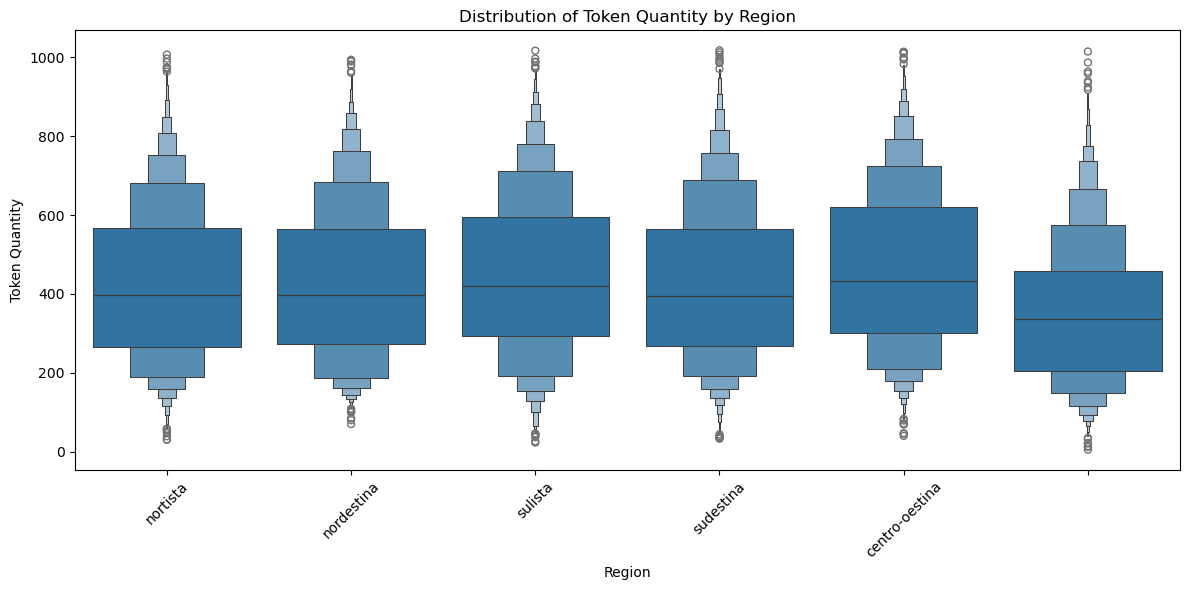

In [212]:
column = 'token_quantity'
df_plot = remove_outliers(df, column)
plt.figure(figsize=(12, 6))
sns.boxenplot(x='regiao', y=column, data=df_plot)
plt.title('Distribution of Token Quantity by Region')
plt.xlabel('Region')
plt.ylabel('Token Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

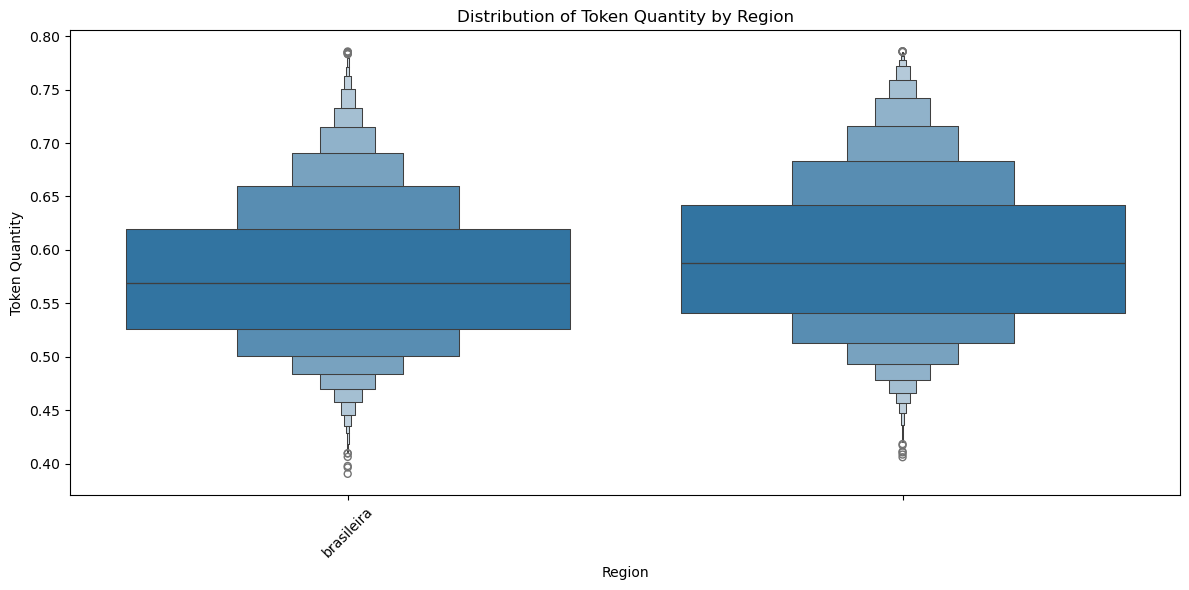

In [213]:
column = 'ttr'
df_plot = remove_outliers(df, column)
plt.figure(figsize=(12, 6))
sns.boxenplot(x='localidade', y=column, data=df_plot)
plt.title('Distribution of Token Quantity by Region')
plt.xlabel('Region')
plt.ylabel('Token Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

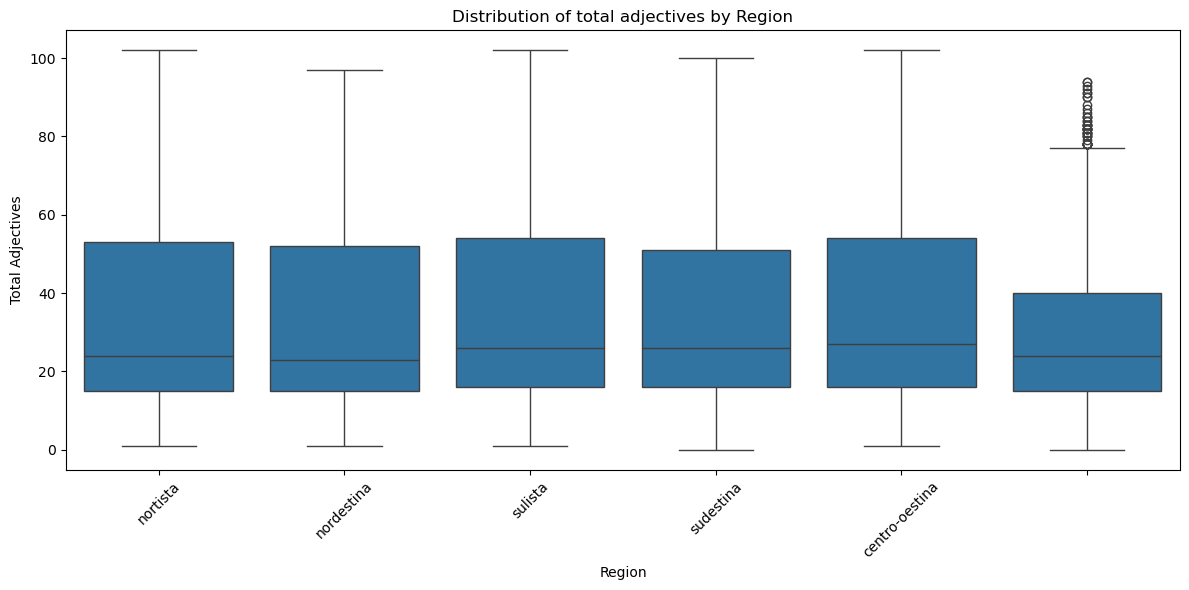

In [214]:
column = 'total_adjectives'
df_plot = remove_outliers(df, column)
plt.figure(figsize=(12, 6))
sns.boxplot(x='regiao', y=column, data=df_plot)
plt.title('Distribution of total adjectives by Region')
plt.xlabel('Region')
plt.ylabel('Total Adjectives')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


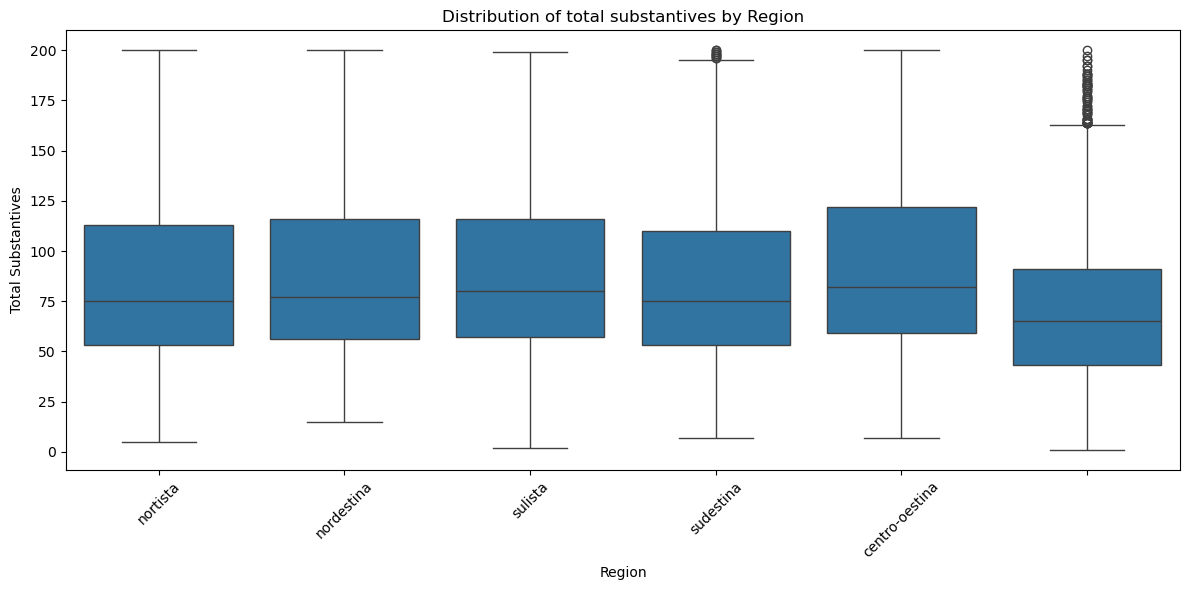

In [215]:
column = 'total_substantives'
df_plot = remove_outliers(df, column)
plt.figure(figsize=(12, 6))
sns.boxplot(x='regiao', y=column, data=df_plot)
plt.title('Distribution of total substantives by Region')
plt.xlabel('Region')
plt.ylabel('Total Substantives')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [216]:
df.columns

Index(['messageId', 'trait', 'original_prompt', 'model', 'response',
       'responseId', 'udpipe_result', 'MLC', 'MLS', 'DCC', 'CPC',
       'profundidade_media', 'profundidade_max', 'ttr', 'lexical_density',
       'token_quantity', 'total_adjectives', 'total_substantives',
       'adjective_counter', 'substantive_counter', 'genero', 'raca', 'regiao',
       'localidade', 'unused', 'artigo', 'pronome'],
      dtype='object')